# Cable Network Visualization Notebook

This notebook reads cable connection data from an Excel file and visualizes the network architecture of switches and ports using NetworkX and Matplotlib.

## Instructions
1. Upload your Excel file (e.g., `scada_htcable_chain_2000_rows.xlsx`) to the notebook environment.
2. Update the `EXCEL_FILENAME` and `EXCEL_SHEET_NAME` variables in the main execution cell.
3. Run all cells in order to generate the network visualization.

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import openpyxl


In [5]:
def read_data_from_excel(filename="cables.xlsx", sheet_name="Sheet1"):
    cable_data = []
    try:
        wb = openpyxl.load_workbook(filename)
        sheet = wb[sheet_name]
        for row in sheet.iter_rows(min_row=2, values_only=False):
            if not any(cell.value for cell in row):
                continue
            src = str(row[0].value).strip() if row[0].value is not None else ""
            dst = str(row[1].value).strip() if row[1].value is not None else ""
            port_src = str(row[2].value).strip() if row[2].value is not None else ""
            port_dst = str(row[3].value).strip() if row[3].value is not None else ""
            if src and dst and port_src and port_dst:
                cable_data.append((src, dst, port_src, port_dst))
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return []
    except KeyError:
        print(f"Sheet not found: {sheet_name}")
        return []
    except Exception as e:
        print(f"Error reading Excel: {e}")
        return []

    if cable_data:
        print(f"Read {len(cable_data)} connections.")
    else:
        print("No data found.")
    return cable_data


In [6]:
def visualize_cable_architecture(cable_data):
    if not cable_data:
        print("No data to visualize.")
        return

    G = nx.DiGraph()
    edge_labels = {}
    switches = set()

    for src, dst, port_src, port_dst in cable_data:
        switches.update([src, dst])
        G.add_edge(src, dst)
        key = (src, dst)
        label = f"Src: {port_src}\nDst: {port_dst}"
        if key in edge_labels:
            edge_labels[key] += f"\n---\n{label}"
        else:
            edge_labels[key] = label

    plt.figure(figsize=(14, 12))
    pos = nx.spring_layout(G, k=0.6, iterations=70)

    cmap = plt.cm.get_cmap('tab20', len(switches))
    color_map = {sw: cmap(i) for i, sw in enumerate(sorted(switches))}
    node_colors = [color_map[n] for n in G.nodes()]

    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color=node_colors, alpha=0.9)
    nx.draw_networkx_edges(
        G, pos,
        width=1.5, alpha=0.7, edge_color='dimgray',
        arrows=True, arrowstyle='-|>', arrowsize=25,
        connectionstyle='arc3,rad=0.1'
    )
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=edge_labels, font_size=7, font_color='navy',
        bbox=dict(facecolor='whitesmoke', edgecolor='none', alpha=0.6, boxstyle='round,pad=0.2')
    )

    plt.title("Cable Network Architecture", fontsize=18)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


Read 191 connections.


/tmp/ipykernel_30834/3425890996.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(switches))


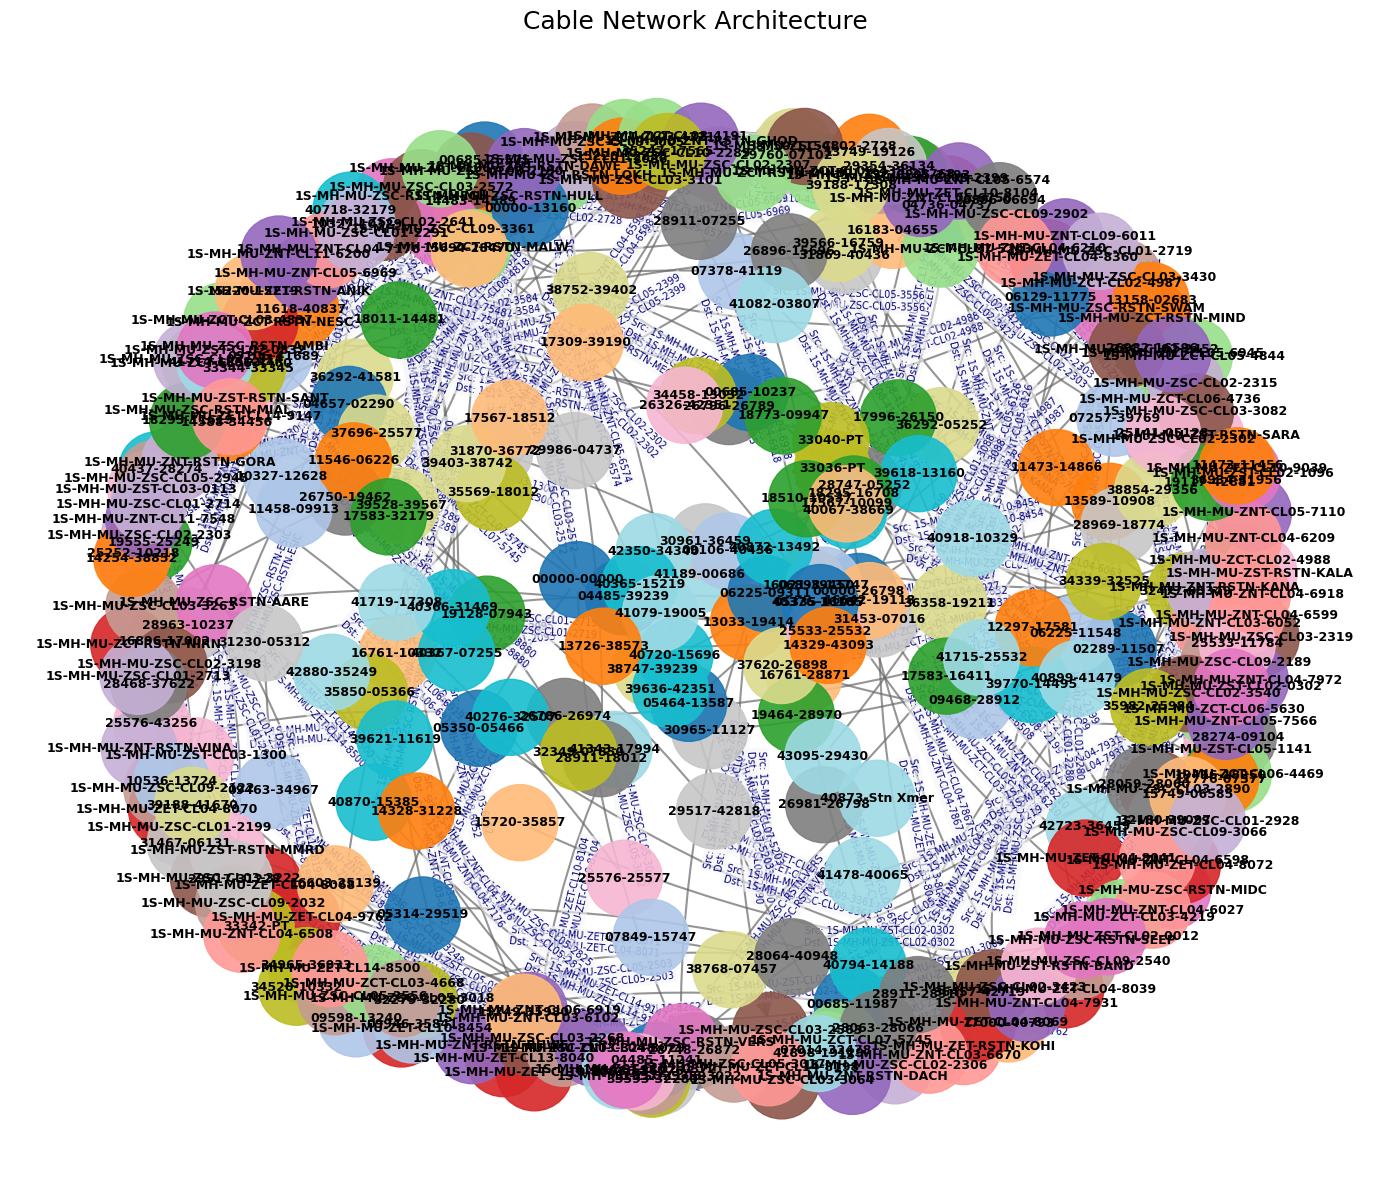

In [7]:
if __name__ == "__main__":
    EXCEL_FILENAME = "scada_htcable_chain_2000_rows.xlsx"
    EXCEL_SHEET_NAME = "Sheet1"

    network_data = read_data_from_excel(EXCEL_FILENAME, EXCEL_SHEET_NAME)
    if network_data:
        visualize_cable_architecture(network_data)
    else:
        print(f"Could not load data from '{EXCEL_FILENAME}'.")


Error reading edge sheet: 'Worksheet Edges does not exist.'
Error reading location sheet: 'Worksheet Locations does not exist.'


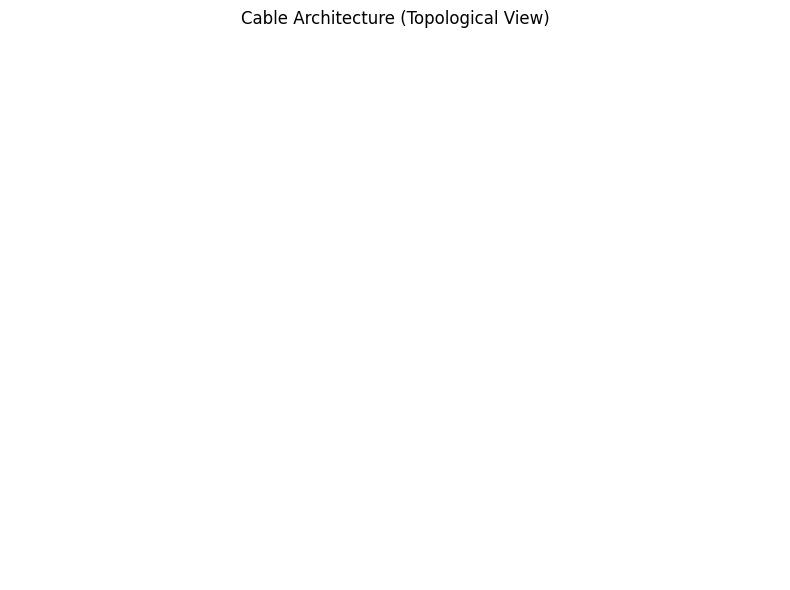

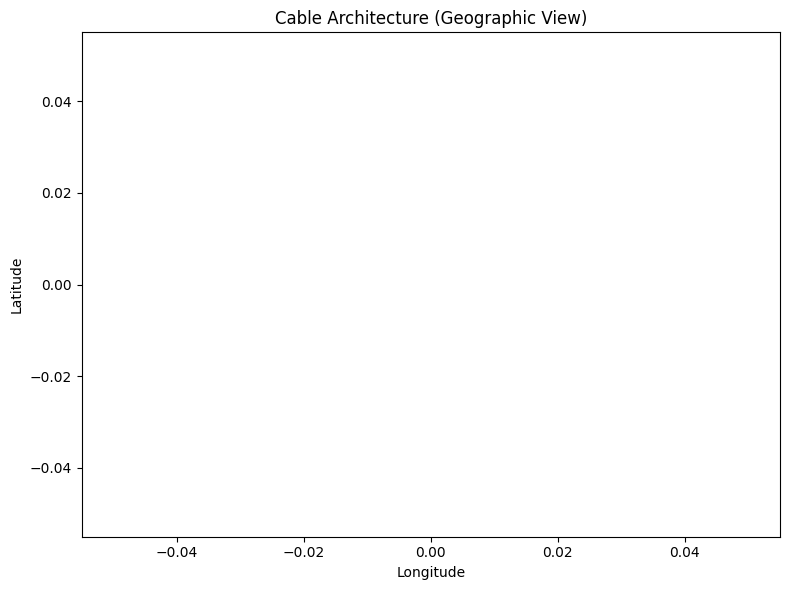

In [10]:
import openpyxl
import networkx as nx
import matplotlib.pyplot as plt

def read_cable_edges(filename="cables_with_locations.xlsx", edge_sheet="Edges"):
    edges = []
    try:
        wb = openpyxl.load_workbook(filename, data_only=True)
        sheet = wb[edge_sheet]
        for row in sheet.iter_rows(min_row=2, values_only=True):
            src_id = str(row[0]).strip() if row[0] is not None else ""
            dst_id = str(row[1]).strip() if row[1] is not None else ""
            src_port = str(row[2]).strip() if row[2] is not None else ""
            dst_port = str(row[3]).strip() if row[3] is not None else ""
            if src_id and dst_id and src_port and dst_port:
                edges.append((src_id, dst_id, src_port, dst_port))
    except Exception as e:
        print("Error reading edge sheet:", e)
    return edges

def read_switch_locations(filename="cables_with_locations.xlsx", loc_sheet="Locations"):
    loc_map = {}
    try:
        wb = openpyxl.load_workbook(filename, data_only=True)
        sheet = wb[loc_sheet]
        for row in sheet.iter_rows(min_row=2, values_only=True):
            sw_id = str(row[0]).strip() if row[0] is not None else ""
            lat = row[1]
            lon = row[2]
            if sw_id and lat is not None and lon is not None:
                loc_map[sw_id] = (float(lat), float(lon))
    except Exception as e:
        print("Error reading location sheet:", e)
    return loc_map

def build_graph(edges):
    G = nx.DiGraph()
    for src, dst, src_port, dst_port in edges:
        G.add_edge(src, dst, label=f"{src_port} → {dst_port}")
    return G

def draw_topology(G):
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    nx.draw_networkx_nodes(G, pos, node_size=800, node_color="#66c2a5")
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', arrowsize=20, width=2)
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold")
    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    plt.title("Cable Architecture (Topological View)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def draw_geographic(G, loc_map):
    # Only include nodes that have coordinates
    coords = {n: loc_map[n] for n in G.nodes() if n in loc_map}
    missing = set(G.nodes()) - set(coords.keys())
    if missing:
        print("Warning: Missing coordinates for:", missing)

    plt.figure(figsize=(8, 6))
    # plot nodes at their lat/lon
    xs = [coords[n][1] for n in coords]  # treat coords as (lat, lon)
    ys = [coords[n][0] for n in coords]
    plt.scatter(xs, ys, s=100, c="#fc8d62", zorder=2)
    for n in coords:
        x, y = coords[n][1], coords[n][0]
        plt.text(x, y, n, fontsize=9, fontweight="bold", ha="right", va="bottom")

    # draw edges as straight lines between node coords
    for u, v in G.edges():
        if u in coords and v in coords:
            lat1, lon1 = coords[u]
            lat2, lon2 = coords[v]
            plt.plot([lon1, lon2], [lat1, lat2], "-", color="#8da0cb", linewidth=1.5, zorder=1)
            # optionally, annotate port info at midpoint
            lbl = G[u][v]["label"]
            mid_x = (lon1 + lon2) / 2
            mid_y = (lat1 + lat2) / 2
            plt.text(mid_x, mid_y, lbl, fontsize=6, color="navy", ha="center", va="center")

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Cable Architecture (Geographic View)")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    EXCEL_FILE = "scada_htcable_chain_2000_rows.xlsx"
    edges = read_cable_edges(EXCEL_FILE, edge_sheet="Edges")
    locs = read_switch_locations(EXCEL_FILE, loc_sheet="Locations")
    G = build_graph(edges)

    # 1) Draw pure topology
    draw_topology(G)

    # 2) Draw “real‐life” placement
    draw_geographic(G, locs)


In [3]:
import pandas as pd
from pyvis.network import Network

df = pd.read_csv('/media/sagarkumar/New Volume/SAGAR/IPYNB_FILE/final_two_column_with_rank_11_full.csv')
feeder_ids = df['FEEDER_ID'].dropna().unique().tolist()[:100]  # show  feeders
sub_df = df[df['FEEDER_ID'].isin(feeder_ids)]
sub_df = sub_df.dropna(subset=['SOURCE_LOCATION', 'DESTINATION_LOCATION'])

nt = Network(height="800px", width="100%", notebook=True, directed=True)
for idx, row in sub_df.iterrows():
    src = str(row['SOURCE_LOCATION'])
    dst = str(row['DESTINATION_LOCATION'])
    nt.add_node(src, label=src)
    nt.add_node(dst, label=dst)
    nt.add_edge(src, dst, label=str(row['RANK']))
nt.show("feeder_network.html")

feeder_network.html
